# Truncated MAC address mobility measurement

We take an idealised model of Euston station, inspired by a case study from the [Review of the TfL WiFi pilot](http://content.tfl.gov.uk/review-tfl-wifi-pilot.pdf). There are two locations (A and B), and some customers travel between them by the slow path (taking 3–5 minutes) and some by the fast path (taking 1–3 minutes). Some customers also arrive at one location and leave again at the same location. From measurements of MAC addresses at locations A and B, timestamped with second precision, we wish to infer what proportion of customers take each path.

We consider two scenarios. Firstly, we assume that the full 48-bit MAC address is recorded, and therefore there is neglible probability of two customers having the same MAC address. Secondly, we assume that for privacy reasons the recorded MAC address is truncated to 16 bits and therefore many measurements of different customers will appear to have the same MAC address.

The question we aim to address is that, in the privacy-preserving case, how much worse are the inferred conclusions? The simulation is quite basic, not very performant and the inferrence algorithm is particularly simple-minded. This work is intended as a starting point for discussion rather than being useful in itself.

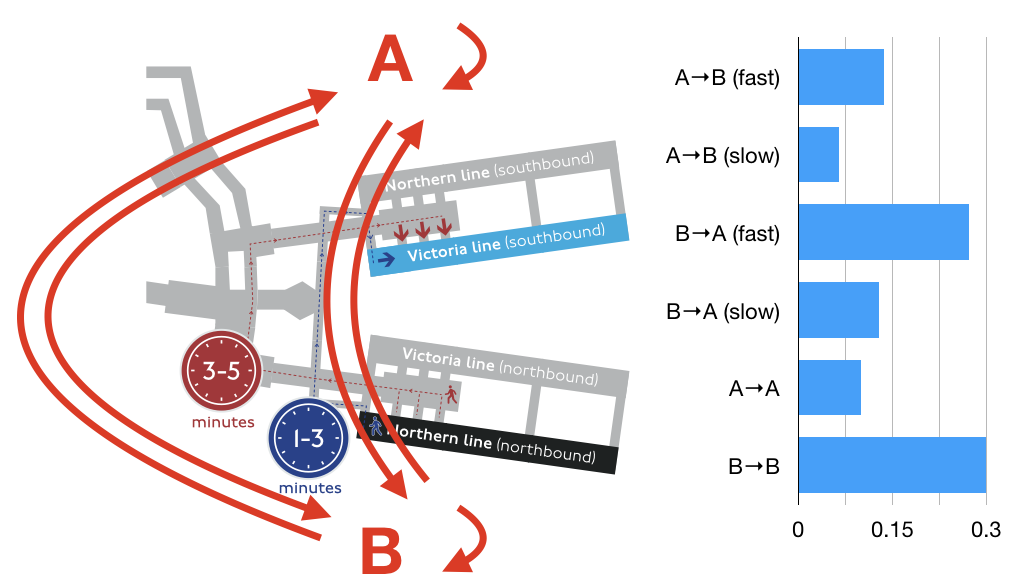

In [1]:
### Copyright 2019 Steven J. Murdoch
### 
### Licensed under the Apache License, Version 2.0 (the "License");
### you may not use this file except in compliance with the License.
### You may obtain a copy of the License at
### 
###   http://www.apache.org/licenses/LICENSE-2.0
### 
### Unless required by applicable law or agreed to in writing, software
### distributed under the License is distributed on an "AS IS" BASIS,
### WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
### See the License for the specific language governing permissions and
### limitations under the License.

## Set up environment and parameters
import random
import math
import secrets
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## For each scenario, how many simulations do we run?
NUMSIMS = 100
## 1 customer per second is vaguly plausible for Euston's 42 million annual customers
RATE = 1 # people per second
## How long to run each simulation
TIME = 18 * 60 * 60 # 18 hours, in seconds
## A small number for dealing with floating point error
EPSILON = 0.0000001

## Average time for paths (from figures on p34 in http://content.tfl.gov.uk/review-tfl-wifi-pilot.pdf)
TIME_FAST = 120 # fast path in seconds
TIME_SLOW = 240 # slow path in seconds
TIME_STDDEV = 30 # standard deviation for path (chosen arbitrarily)
TIME_CUTOFF = 180 # over which duration to be assume a path was long

## Probabilities for each speed (from figures on p34 in http://content.tfl.gov.uk/review-tfl-wifi-pilot.pdf)
PF=0.68 ## That a random customer will take the fast path
PS=1-PF ## That a random customer will take the slow path
assert(abs(1-(PF+PS)) < EPSILON)

## Probabilities for each path (arbitrarily selected)
PAB=0.2 ## From A to B
PBA=0.4 ## From B to A
PAA=0.1 ## Enter and exit at A
PBB=0.3 ## Enter and exit at B
assert(abs(1-(PAB+PBA+PAA+PBB)) < EPSILON)

## Probabilities for each case (assumes independence)
PAB_F=PAB*PF ## A to B (fast)
PAB_S=PAB*PS ## A to B (slow)
PBA_F=PBA*PF ## B to A (fast)
PBA_S=PBA*PS ## B to A (slow)
assert(abs(1-(PAB_F+PAB_S+PBA_F+PBA_S+PAA+PBB)) < 0.0001)

## Calculate cumulative probabilities for each case to help select biased random values
C1 = PAB_F      # A->B (fast)
C2 = PAB_S + C1 # A->B (slow)
C3 = PBA_F + C2 # B->A (fast)
C4 = PBA_S + C3 # B->A (slow)
C5 = PAA   + C4 # A->A
C6 = PBB   + C5 # B->B
assert (abs(1 - C6) < EPSILON)

## Enumeration for the cases
CASE_ABF = 1
CASE_ABS = 2
CASE_BAF = 3
CASE_BAS = 4
CASE_AA  = 5
CASE_BB  = 6
MAX_CASES = CASE_BB

## Enumeration for the locations
A = 0
B = 1

In [2]:
def whichcase():
    '''Return a case such that each case is selected with the probabilities
    specified by C1 .. C6'''
    n = random.random()
    if n < C1:
        return 1
    elif n < C2:
        return 2
    elif n < C3:
        return 3
    elif n < C4:
        return 4
    elif n < C5:
        return 5
    else:
        return 6
    
def waitingtime(isfast):
    '''Return the travel time, taking the fast route if isfast is True and slow otherwise'''
    if isfast:
        return round(np.random.normal(TIME_FAST, TIME_STDDEV))
    else:
        return round(np.random.normal(TIME_SLOW, TIME_STDDEV))

In [28]:
def runsim(bits):
    '''Run a single simulation of MAC address measurement of length bits.
    Returns (entry events, exit events, MAC addresses seen)'''
    
    ## For each case, how often has it occurred
    cases = collections.defaultdict(int)
    ## For each MAC, a list of (time, location) of entry events
    evin = collections.defaultdict(list)
    ## For each MAC, a list of (time, location) of exit events
    evout = collections.defaultdict(list)
    ## What MAC addresses have we seen
    macs = set()
    
    ## Simulate each second
    for tick in range(TIME):
        ## How many people arrived this second?
        npeople = np.random.poisson(RATE)
        for i in range(npeople):
            ## Assume random MAC addresses -- not true but we are well away from
            ## the birthday paradox point for 48 bit MAC addresses
            mac = secrets.randbits(bits)
            macs.add(mac)
            
            ## Generate a random case
            case = whichcase()
            cases[case] += 1
            
            ## Log the entry event at this tick 
            if case == CASE_ABF or case == CASE_ABS or case == CASE_AA:
                evin[mac].append((tick, A)) # from A
            else:
                evin[mac].append((tick, B)) # from B
                
            ## If there is an exit event, find the time and log it
            if case == CASE_ABF:
                waiting = waitingtime(True)
                evout[mac].append((tick + waiting, B)) 
            elif case == CASE_ABS:
                waiting = waitingtime(False)
                evout[mac].append((tick + waiting, B)) 
            elif case == CASE_BAF:
                waiting = waitingtime(True)
                evout[mac].append((tick + waiting, A))
            elif case == CASE_BAS:
                waiting = waitingtime(False)
                evout[mac].append((tick + waiting, A))
                
    return evin, evout, macs

def runinfer(evin, evout, macs):
    '''Given (entry events, exit events, MAC addresses seen), infer paths taken.
    Returns a mapping beween case ID and number of occurrences'''
    cases = collections.defaultdict(int)
    
    ## For each MAC address, which path was taken? For simplicity, we only look at
    ## the first time this MAC address enters and the first time it leaves. When
    ## MAC addresses are unique, this is fine but when there are collisions this will
    ## mean that real events will be missed
    for mac in macs:
        ins = evin[mac] # Entry events for this MAC address
        outs = evout[mac] # Exit events for this MAC address
        
        ## No exit, so assume AA or BB based on where MAC first seen
        if len(outs) == 0: ## AA or BB
            if ins[0][1] == A:
                case = CASE_AA
            else:
                case = CASE_BB
                
        ## MAC seen entering A and exiting at B
        elif ins[0][1] == A and outs[0][1] == B:
            duration = outs[0][0] - ins[0][0]
            if duration > 0 and duration <= TIME_CUTOFF:
                case = CASE_ABF
            else:
                case = CASE_ABS
                
        ## MAC seen entering B and exiting at A
        elif ins[0][1] == B and outs[0][1] == A:
            duration = outs[0][0] - ins[0][0]
            if duration > 0 and duration <= TIME_CUTOFF:
                case = CASE_BAF
            else:
                case = CASE_BAS
        
        ## Inference has failed, e.g. where ins = [(11611, A), (60964, B)]
        ## and out = [(61129, A)], there is a collision between A->A and A->B 
        ## but we only look at the first entry event and first out event
        else:
            case = 0
            
        ## Record the inferred case
        cases[case] += 1
        
    return cases

def runscenario(bits):
    '''Run a set of simulations for a scenario of MACs of length bits'''
    ## For each case, a list of results of each simulation showing 
    ## the proportion of the MAC addresses inferred to belong to this case
    stats = collections.defaultdict(list)
    for sim in range(NUMSIMS):
        ## Run the simulation to get events and MAC addresses
        evin, evout, macs = runsim(bits)
        ## From the events and MAC addresses infer the occurrences of each case
        cases = runinfer(evin, evout, macs)
        ## Number of occurrence of all cases (excluding unknown)
        total = sum([cases.get(i, 0) for i in range(1, MAX_CASES + 1)])
        for i in range(0, MAX_CASES + 1):
            ## Compute proportion for each case in this simulation
            stats[i].append(cases.get(i, 0)/total)
    return stats

def doplot(stats, axes):
    data = [sorted(stats.get(i,[0])) for i in range(0, MAX_CASES + 1)]
    axes.violinplot(data)
    axes.scatter(range(1, MAX_CASES + 2), [0, PAB_F, PAB_S, PBA_F, PBA_S, PAA, PBB], marker='o', color='red', s=30, zorder=3)
    axes.set_xticks(range(1, MAX_CASES + 2))
    axes.set_xticklabels(['unknown', 'A→B (fast)', 'A→B (slow)', 'B→A (fast)', 'B→A (slow)', 'A→A', 'B→B'])

In [4]:
## Run the two scenarios
stats48 = runscenario(48)
stats16 = runscenario(16)

<IPython.core.display.Javascript object>


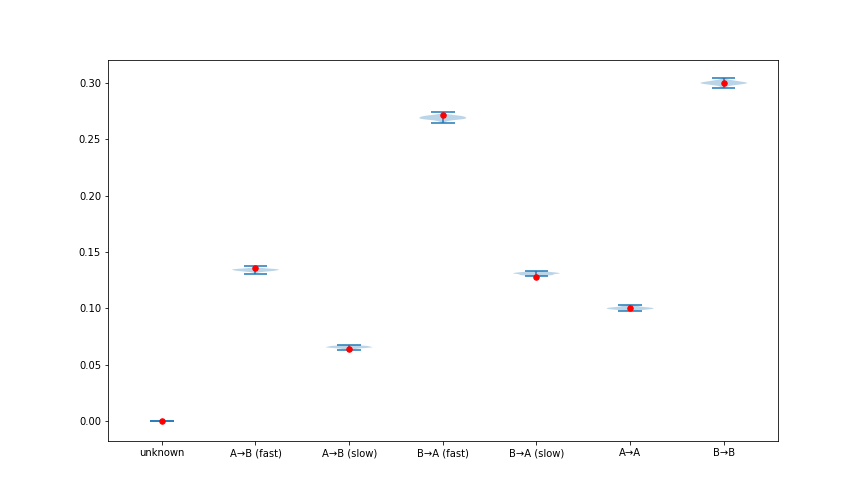

In [35]:
## Plot the non-privacy-preserving case
fig, axes = plt.subplots(figsize=(12, 7))
doplot(stats48, axes)

<IPython.core.display.Javascript object>


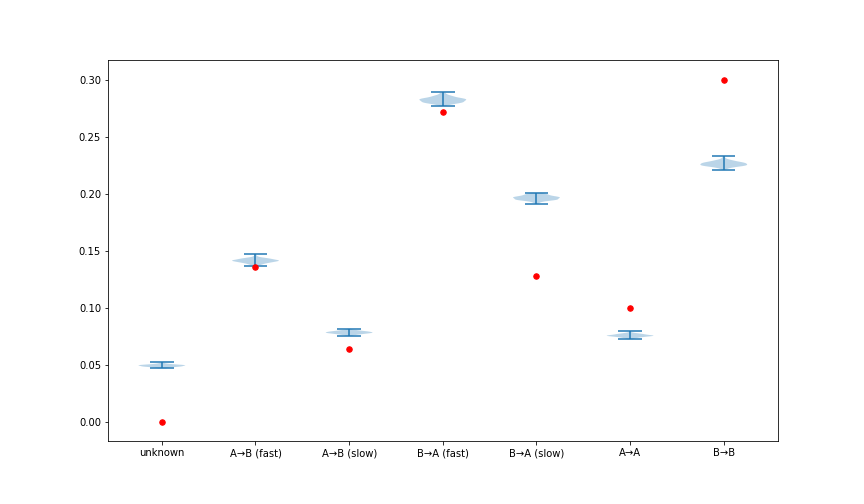

In [36]:
## Plot the privacy-preserving case
fig, axes = plt.subplots(figsize=(12, 7))
doplot(stats16, axes)